In [79]:
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [80]:
%config InlineBackend.figure_format = 'retina'

In [81]:
DIR_ITERATIVE_BASELINE = (
    "../experiments/outputs/compositional_graphics/logo_stitch_iterative/*"
)
DIR_ITERATIVE_CODEX = (
    "../experiments/outputs/compositional_graphics/logo_codex_stitch_iterative/*"
)

In [82]:
def get_log_likelihoods(dir_results):
    data = []

    for path in sorted(glob.glob(dir_results)):
        config_json_path = os.path.join(path, "config.json")
        with open(config_json_path, "r") as f:
            config = json.load(f)
        global_batch_size = config["experiment_iterator"]["task_batcher"]["params"][
            "global_batch_size"
        ]

        test_likelihoods_json_path = os.path.join(path, "0", "test_likelihoods.json")
        with open(test_likelihoods_json_path, "r") as f:
            likelihoods_data = json.load(f)

        stitch_frontiers_json_path = os.path.join(
            path, "0", "train", "stitch_frontiers.json"
        )
        with open(stitch_frontiers_json_path, "r") as f:
            stitch_frontiers_data = json.load(f)

        for task_name, ll_list in likelihoods_data["log_likelihoods_by_task"][
            "test"
        ].items():
            data.append(
                {
                    "batch_size": global_batch_size,
                    "task_name": task_name,
                    "log_likelihood": ll_list[0],
                    "n_frontiers": len(stitch_frontiers_data["frontiers"]),
                }
            )

    df = pd.DataFrame(data)
    return df

In [83]:
df1 = get_log_likelihoods(DIR_ITERATIVE_BASELINE)
df1["condition"] = "Stitch"

# df2 = None

df2 = get_log_likelihoods(DIR_ITERATIVE_CODEX)
df2["condition"] = "Stitch + Codex"

In [84]:
df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

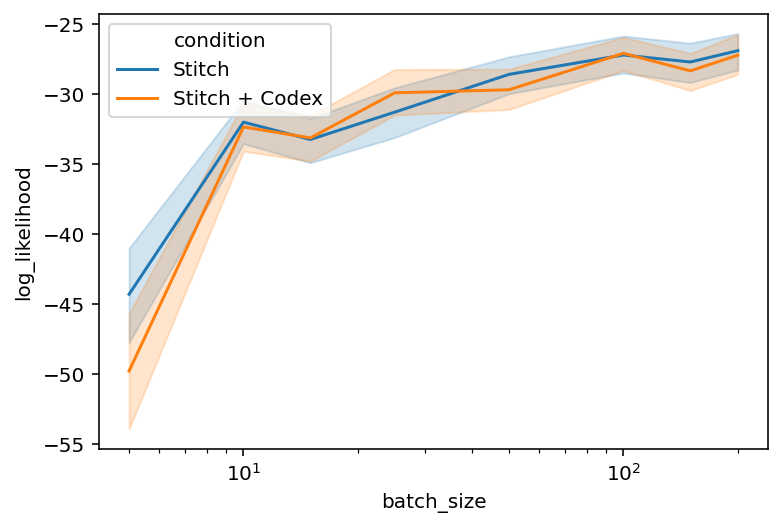

In [86]:
g = sns.lineplot(data=df, x="batch_size", y="log_likelihood", hue="condition")
g.set(xscale="log");

<AxesSubplot:xlabel='batch_size', ylabel='log_likelihood'>

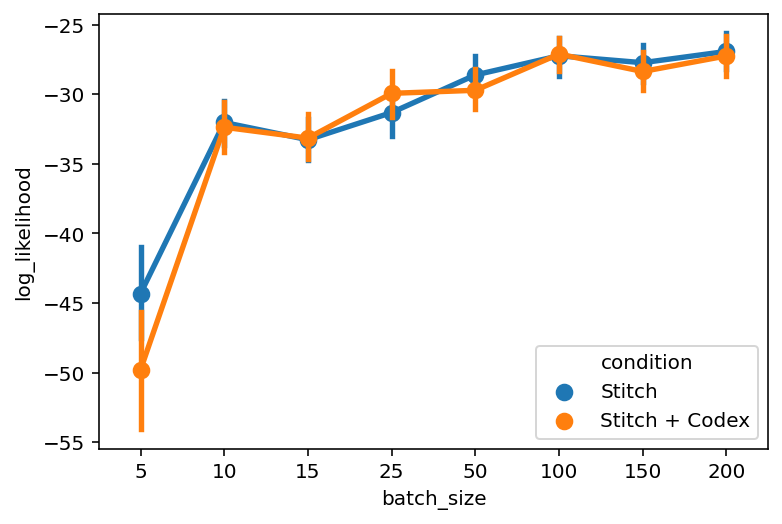

In [87]:
sns.pointplot(data=df, x="batch_size", y="log_likelihood", hue="condition")

<AxesSubplot:xlabel='batch_size', ylabel='n_frontiers'>

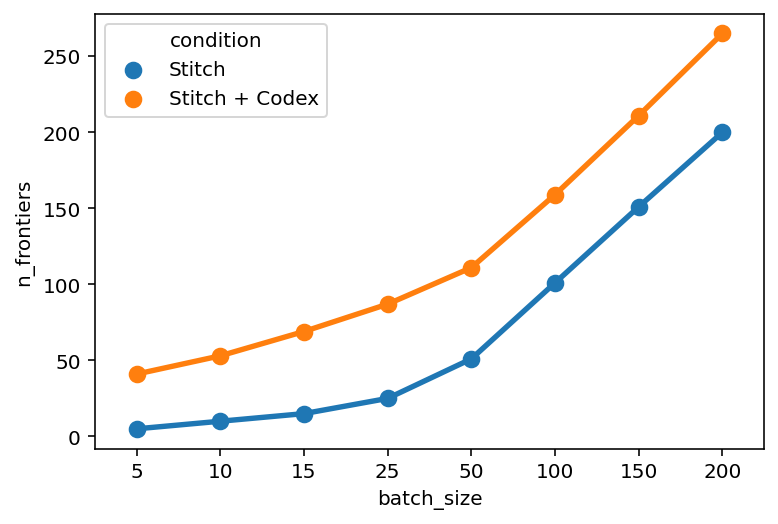

In [88]:
sns.pointplot(data=df, x="batch_size", y="n_frontiers", hue="condition")

<AxesSubplot:xlabel='n_frontiers', ylabel='log_likelihood'>

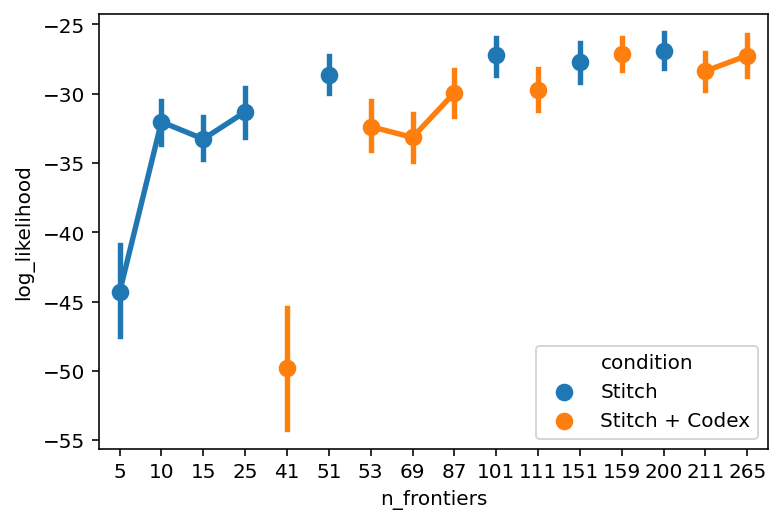

In [89]:
sns.pointplot(data=df, x="n_frontiers", y="log_likelihood", hue="condition")

## What programs does Codex generate?

In [167]:
BATCH_SIZE = 25
codex_query_results_json_path = f"../experiments/outputs/compositional_graphics/logo_codex_stitch_iterative/logo_codex_stitch_iterative_{BATCH_SIZE}/0/codex_query_results.json"

with open(codex_query_results_json_path, "r") as f:
    codex_query_results = json.load(f)

In [168]:
data = []
for p in codex_query_results["prompt_programs"]:
    data.append(
        {
            "program": p,
            "origin": "train",
            "valid": True,
        }
    )
for p in codex_query_results["programs_valid"]:
    data.append(
        {
            "program": p,
            "origin": "codex",
            "valid": True,
        }
    )
for p in codex_query_results["programs_invalid"]:
    data.append(
        {
            "program": p,
            "origin": "codex",
            "valid": False,
        }
    )

df = pd.DataFrame(data)
df["program_str_len"] = df.program.str.len()

In [169]:
print(f"+ From {BATCH_SIZE} training programs, Codex generated {len(df[df.origin == 'codex'])} programs, for a total of {len(df)} programs.")
print(f"+ Of these, {len(df[(df.origin == 'codex') & (df.valid)])} were valid and {len(df[(df.origin == 'codex') & (~df.valid)])} were invalid.")
print(f"+ In total, there were {df['program'].nunique()} unique programs; {df[df.valid]['program'].nunique()} were valid.")

copied_programs = set(codex_query_results["programs_valid"]) & set(codex_query_results["prompt_programs"])
print(f"+ {len(copied_programs)} of the Codex programs were direct copies from the training data.")

+ From 25 training programs, Codex generated 100 programs, for a total of 125 programs.
+ Of these, 71 were valid and 29 were invalid.
+ In total, there were 115 unique programs; 86 were valid.
+ 0 of the Codex programs were direct copies from the training data.


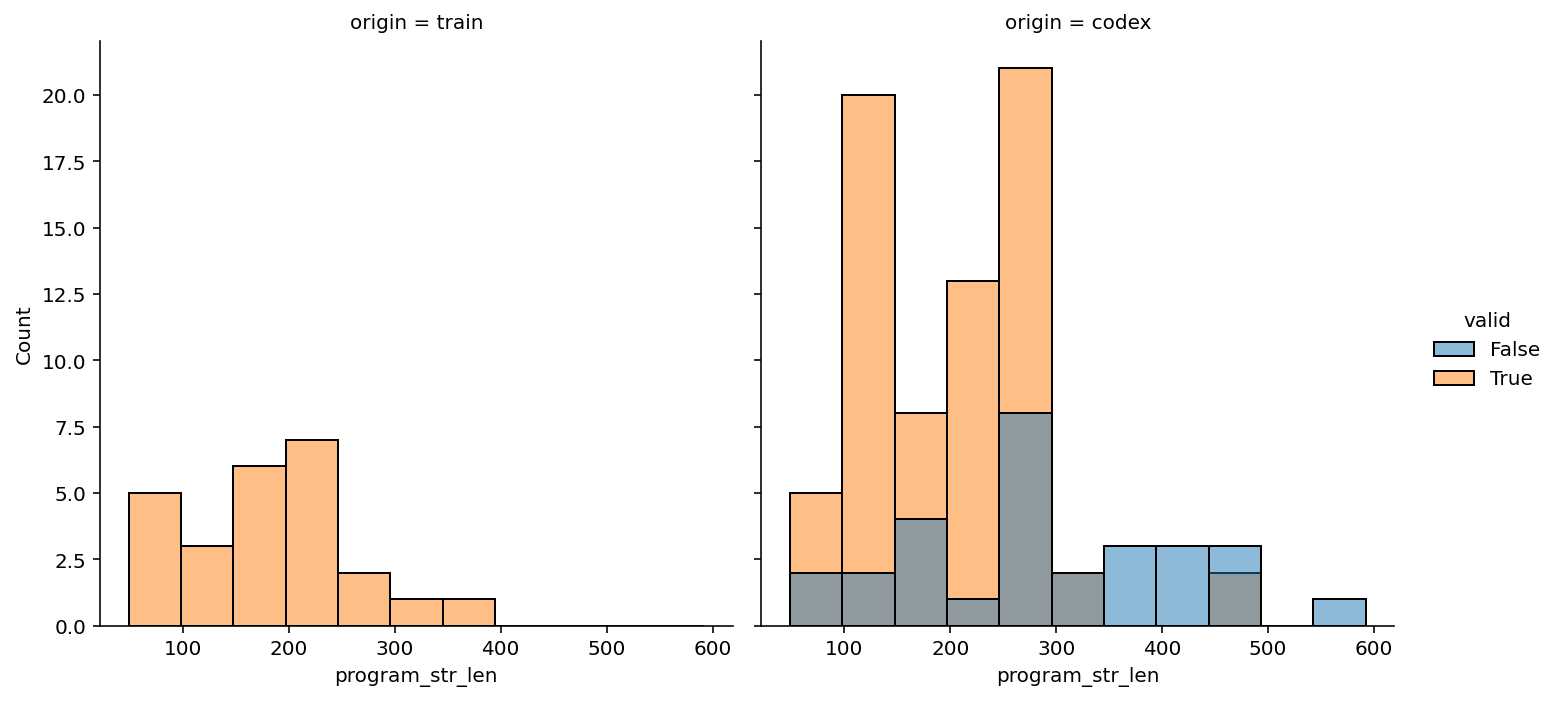

In [170]:
sns.displot(data=df, x="program_str_len", hue="valid", col="origin")

In [171]:
df.program[df.origin == "train"].tolist()

['(lambda (fn_26 fn_9 (lambda (lambda (fn_13 (fn_17 fn_21 fn_1) (fn_11 fn_20 fn_9) $0))) (fn_18 (lambda (fn_13 (fn_17 fn_21 fn_2) fn_22 $0)) (fn_26 fn_4 (lambda (lambda (fn_13 (fn_17 fn_21 fn_2) (fn_11 fn_20 fn_4) $0))) $0))))',
 '(lambda (fn_26 fn_4 (lambda (lambda (fn_14 (lambda (fn_26 fn_15 (lambda (lambda (fn_13 (fn_17 fn_25 fn_2) fn_24 $0))) $0)) (fn_18 (lambda (fn_13 fn_21 fn_22 $0)) $0)))) $0))',
 '(lambda (fn_26 fn_7 (lambda (lambda (fn_14 (lambda (fn_18 (lambda (fn_13 fn_21 fn_22 $0)) (fn_26 fn_15 (lambda (lambda (fn_13 (fn_17 fn_25 fn_2) fn_24 $0))) (fn_26 fn_15 (lambda (lambda (fn_13 (fn_17 fn_25 fn_2) fn_24 $0))) (fn_18 (lambda (fn_13 fn_21 fn_22 $0)) (fn_26 fn_5 (lambda (lambda (fn_13 (fn_17 fn_21 fn_1) (fn_11 fn_20 fn_5) $0))) $0)))))) (fn_13 fn_23 (fn_11 fn_20 fn_7) $0)))) $0))',
 '(lambda (fn_26 fn_7 (lambda (lambda (fn_14 (lambda (fn_18 (lambda (fn_13 (fn_17 fn_21 fn_1) fn_22 $0)) (fn_26 fn_3 (lambda (lambda (fn_13 (fn_17 fn_21 fn_2) (fn_11 fn_20 fn_3) $0))) $0))) (fn_

In [172]:
df.program[df.origin == "codex"].tolist()

['(lambda (logo_FWRT (logo_MULL logo_UL 1) (logo_DIVA logo_UA 8) $0))',
 '(lambda (logo_forLoop 9 (lambda (lambda (logo_FWRT (logo_MULL logo_UL 1) (logo_DIVA logo_UA 9) $0))) (logo_FWRT (logo_MULL logo_epsL 3) (logo_DIVA logo_UA 4) $0)))',
 '(lambda (logo_forLoop 7 (lambda (lambda (logo_GETSET (lambda (logo_forLoop 9 (lambda (lambda (logo_FWRT (logo_MULL logo_UL 1) (logo_DIVA logo_UA 9) $0))) $0)) (logo_FWRT logo_ZL (logo_DIVA logo_UA 7) $0)))) $0))',
 '(lambda (logo_forLoop 6 (lambda (lambda (logo_GETSET (lambda (logo_FWRT (logo_MULL logo_UL 1) logo_ZA (logo_forLoop 4 (lambda (lambda (logo_FWRT (logo_MULL logo_UL 1) (logo_DIVA logo_UA 4) $0))) $0))) (logo_FWRT logo_ZL (logo_DIVA logo_UA 6) $0)))) $0))',
 '(lambda (logo_forLoop 8 (lambda (lambda (logo_FWRT (logo_MULL logo_UL 1) (logo_DIVA logo_UA 8) $0))) (logo_PT (lambda (logo_FWRT (logo_MULL logo_UL 2) logo_ZA $0)) (logo_forLoop 8 (lambda (lambda (logo_FWRT (logo_MULL logo_UL 1) (logo_DIVA logo_UA 8) $0))) $0))))',
 '(lambda (logo_fo